In [1]:
import os
import numpy as np
from PIL import Image
import torch
import pickle
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets.DirectoryIteratorWithBoundingBoxes import DirectoryIteratorWithBoundingBoxes
from models.vgg4WithLocalization import Vgg4WithLocalizationConfiguration, Vgg4Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [2]:
# Current working directory
cwd = os.getcwd()
print("Current Working Directory:", cwd)

# Base path
base_path = os.path.join(cwd, "datasets","data", "data", "muscima_split")

# Correct paths for train, val, and test splits
train_xml_directory = os.path.join(base_path, "train", "annotations")
train_img_directory = os.path.join(base_path, "train", "sheet_music")
train_output_path = os.path.join(base_path, "train", "bounding_boxes.pkl")

val_xml_directory = os.path.join(base_path, "val", "annotations")
val_img_directory = os.path.join(base_path, "val", "sheet_music")
val_output_path = os.path.join(base_path, "val", "bounding_boxes.pkl")

test_xml_directory = os.path.join(base_path, "test", "annotations")
test_img_directory = os.path.join(base_path, "test", "sheet_music")
test_output_path = os.path.join(base_path, "test", "bounding_boxes.pkl")

json_path = os.path.join(cwd,'MUSCIMA_class_splits.json')

Current Working Directory: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer


In [3]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

# Check if paths exist
for path in [train_output_path, val_output_path, test_output_path]:
    if not os.path.exists(path):
        print(f"File not found: {path}")
        raise FileNotFoundError(f"The file {path} does not exist. Check your paths.")

# Load bounding boxes
with open(train_output_path, 'rb') as f:
    train_bboxes = pickle.load(f)

with open(val_output_path, 'rb') as f:
    val_bboxes = pickle.load(f)

with open(test_output_path, 'rb') as f:
    test_bboxes = pickle.load(f)

# Extract the classes
def extract_classes_from_bboxes(bbox_dict):
    """
    Extract unique class labels from bounding box annotations.

    Args:
        bbox_dict (dict): Bounding box dictionary with filenames as keys and a list of bounding box annotations.

    Returns:
        list: Sorted list of unique class labels.
    """
    class_set = set()
    for filename, annotations in bbox_dict.items():
        if isinstance(annotations, list):
            for bbox in annotations:
                if isinstance(bbox, dict):
                    if 'className' in bbox:
                        class_set.add(bbox['className'])
                    elif 'label' in bbox:
                        class_set.add(bbox['label'])
                    else:
                        print(f"Warning: No 'class' or 'label' key found in bbox for {filename}: {bbox}")
                else:
                    print(f"Warning: Unexpected bbox format for {filename}: {bbox}")
        else:
            print(f"Warning: Unexpected annotations format for {filename}: {annotations}")
    return sorted(class_set)


classes = extract_classes_from_bboxes(train_bboxes)
print("Extracted Classes:", classes)

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Datasets
train_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=train_img_directory,
    bounding_boxes=train_bboxes,
    target_size=(256, 256),
    transform=transform,
    class_mode="categorical",
    classes=classes
)

val_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=val_img_directory,
    bounding_boxes=val_bboxes,
    target_size=(256, 256),
    transform=transform,
    class_mode="categorical",
    classes=classes
)

test_dataset = DirectoryIteratorWithBoundingBoxes(
    directory=test_img_directory,
    bounding_boxes=test_bboxes,
    target_size=(256, 256),
    transform=transform,
    class_mode="categorical",
    classes=classes
)





Extracted Classes: ['accidentalDoubleSharp', 'accidentalFlat', 'accidentalNatural', 'accidentalSharp', 'arpeggio', 'articulationAccent', 'articulationStaccato', 'articulationTenuto', 'augmentationDot', 'barline', 'barlineHeavy', 'beam', 'brace', 'bracket', 'breathMark', 'cClef', 'characterCapitalA', 'characterCapitalC', 'characterCapitalE', 'characterCapitalF', 'characterCapitalL', 'characterCapitalM', 'characterCapitalP', 'characterCapitalR', 'characterCapitalS', 'characterCapitalT', 'characterCapitalV', 'characterDot', 'characterOther', 'characterSmallA', 'characterSmallB', 'characterSmallC', 'characterSmallD', 'characterSmallE', 'characterSmallF', 'characterSmallG', 'characterSmallI', 'characterSmallJ', 'characterSmallL', 'characterSmallM', 'characterSmallN', 'characterSmallO', 'characterSmallP', 'characterSmallR', 'characterSmallS', 'characterSmallT', 'characterSmallU', 'characterSmallV', 'characterSmallX', 'characterSmallZ', 'dottedHorizontalSpanner', 'dynamicCrescendoHairpin', 'd

In [4]:
def collate_fn(batch):
    images = torch.stack([img for img, _ in batch])
    labels = [lbl for _, (lbl, _) in batch]  # List of label tensors
    bboxes = [bbox for _, (_, bbox) in batch]  # List of bounding box tensors
    return images, (labels, bboxes)




In [5]:
!pip install torcheval

In [6]:
from torcheval.metrics import MulticlassAUROC

In [15]:
import json

def train_vgg4(model, train_loader, val_loader, device, num_epochs=30, lr=1.0, weight_decay=0, patience=5, save_dir="saved_models"):
    """
    Train the VGG4 model with localization, save the best model, and compute losses.
    """
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"vgg4_lr{lr}_wd{weight_decay}_epochs{num_epochs}.pth")
    metrics_path = os.path.join(save_dir, f"vgg4_lr{lr}_wd{weight_decay}_metrics.json")

    # Losses and optimizer
    classification_criterion = nn.CrossEntropyLoss()
    localization_criterion = nn.SmoothL1Loss()
    optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay)

    model = model.to(device)

    # Metrics storage
    metrics = {"train_class_loss": [], "val_class_loss": []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # -------------------------
        # Training Phase
        # -------------------------
        model.train()
        train_class_loss = 0.0

        for images, (labels, bboxes) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            class_preds, _ = model(images)
            B, C, H, W = class_preds.shape
            class_preds = class_preds.permute(0, 2, 3, 1).reshape(-1, C)

            # Initialize ground truth
            gt_labels = torch.zeros((B, H, W), dtype=torch.long, device=device)
            for b in range(B):
                for label, bbox in zip(labels[b], bboxes[b]):
                    x, y, w, h = bbox.int()
                    x1, x2 = max(0, x), min(W, x + w)
                    y1, y2 = max(0, y), min(H, y + h)
                    gt_labels[b, y1:y2, x1:x2] = label

            gt_labels = gt_labels.flatten()

            # Compute loss
            class_loss = classification_criterion(class_preds, gt_labels)
            class_loss.backward()
            optimizer.step()

            train_class_loss += class_loss.item()

        # -------------------------
        # Validation Phase
        # -------------------------
        model.eval()
        val_class_loss = 0.0

        with torch.no_grad():
            for images, (labels, bboxes) in val_loader:
                images = images.to(device)

                # Forward pass
                class_preds, _ = model(images)
                B, C, H, W = class_preds.shape
                class_preds = class_preds.permute(0, 2, 3, 1).reshape(-1, C)

                # Initialize ground truth
                gt_labels = torch.zeros((B, H, W), dtype=torch.long, device=device)
                for b in range(B):
                    for label, bbox in zip(labels[b], bboxes[b]):
                        x, y, w, h = bbox.int()
                        x1, x2 = max(0, x), min(W, x + w)
                        y1, y2 = max(0, y), min(H, y + h)
                        gt_labels[b, y1:y2, x1:x2] = label

                gt_labels = gt_labels.flatten()

                # Compute loss
                class_loss = classification_criterion(class_preds, gt_labels)
                val_class_loss += class_loss.item()

        # Store losses
        metrics["train_class_loss"].append(train_class_loss / len(train_loader))
        metrics["val_class_loss"].append(val_class_loss / len(val_loader))

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Class Loss: {metrics['train_class_loss'][-1]:.4f}")
        print(f"Val Class Loss: {metrics['val_class_loss'][-1]:.4f}")

        # Save best model
        if metrics['val_class_loss'][-1] < best_val_loss:
            best_val_loss = metrics['val_class_loss'][-1]
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save metrics to a JSON file
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Metrics saved to {metrics_path}")
    print(f"Model saved to {save_path}")

    return model


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

num_epochs=30
lr=0.1
weight_decay=0.0005
patience=5
print("classes: ", classes)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
pth = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths'
model = Vgg4Model((3, 256, 256), num_classes=len(classes),  weight_decay=weight_decay).to(device)
model = train_vgg4(model, train_loader, val_loader, device, num_epochs = num_epochs, patience = patience, lr = lr, save_dir = pth)


Using CPU
classes:  ['accidentalDoubleSharp', 'accidentalFlat', 'accidentalNatural', 'accidentalSharp', 'arpeggio', 'articulationAccent', 'articulationStaccato', 'articulationTenuto', 'augmentationDot', 'barline', 'barlineHeavy', 'beam', 'brace', 'bracket', 'breathMark', 'cClef', 'characterCapitalA', 'characterCapitalC', 'characterCapitalE', 'characterCapitalF', 'characterCapitalL', 'characterCapitalM', 'characterCapitalP', 'characterCapitalR', 'characterCapitalS', 'characterCapitalT', 'characterCapitalV', 'characterDot', 'characterOther', 'characterSmallA', 'characterSmallB', 'characterSmallC', 'characterSmallD', 'characterSmallE', 'characterSmallF', 'characterSmallG', 'characterSmallI', 'characterSmallJ', 'characterSmallL', 'characterSmallM', 'characterSmallN', 'characterSmallO', 'characterSmallP', 'characterSmallR', 'characterSmallS', 'characterSmallT', 'characterSmallU', 'characterSmallV', 'characterSmallX', 'characterSmallZ', 'dottedHorizontalSpanner', 'dynamicCrescendoHairpin', '

Epoch 1/30: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]



Epoch 1/30
Train Class Loss: 0.5633
Val Class Loss: 0.4441


Epoch 2/30: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s]



Epoch 2/30
Train Class Loss: 0.0165
Val Class Loss: 0.0100


Epoch 3/30: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]



Epoch 3/30
Train Class Loss: 0.0050
Val Class Loss: 0.0026


Epoch 4/30: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]



Epoch 4/30
Train Class Loss: 0.0015
Val Class Loss: 0.0009


Epoch 5/30: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]



Epoch 5/30
Train Class Loss: 0.0006
Val Class Loss: 0.0004


Epoch 6/30: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s]



Epoch 6/30
Train Class Loss: 0.0003
Val Class Loss: 0.0003


Epoch 7/30: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]



Epoch 7/30
Train Class Loss: 0.0002
Val Class Loss: 0.0002


Epoch 8/30: 100%|██████████| 29/29 [00:26<00:00,  1.07it/s]



Epoch 8/30
Train Class Loss: 0.0002
Val Class Loss: 0.0002


Epoch 9/30: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]



Epoch 9/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 10/30: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]



Epoch 10/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 11/30: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]



Epoch 11/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 12/30: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]



Epoch 12/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 13/30: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 13/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 14/30: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]



Epoch 14/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 15/30: 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]



Epoch 15/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 16/30: 100%|██████████| 29/29 [00:32<00:00,  1.10s/it]



Epoch 16/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 17/30: 100%|██████████| 29/29 [00:30<00:00,  1.07s/it]



Epoch 17/30
Train Class Loss: 0.0001
Val Class Loss: 0.0001


Epoch 18/30: 100%|██████████| 29/29 [00:30<00:00,  1.05s/it]



Epoch 18/30
Train Class Loss: 0.0000
Val Class Loss: 0.0001


Epoch 19/30: 100%|██████████| 29/29 [00:31<00:00,  1.07s/it]



Epoch 19/30
Train Class Loss: 0.0000
Val Class Loss: 0.0001


Epoch 20/30: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 20/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 21/30: 100%|██████████| 29/29 [00:34<00:00,  1.21s/it]



Epoch 21/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 22/30: 100%|██████████| 29/29 [00:36<00:00,  1.26s/it]



Epoch 22/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 23/30: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it]



Epoch 23/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 24/30: 100%|██████████| 29/29 [00:32<00:00,  1.10s/it]



Epoch 24/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 25/30: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 25/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 26/30: 100%|██████████| 29/29 [00:32<00:00,  1.12s/it]



Epoch 26/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 27/30: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it]



Epoch 27/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 28/30: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it]



Epoch 28/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 29/30: 100%|██████████| 29/29 [00:31<00:00,  1.07s/it]



Epoch 29/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000


Epoch 30/30: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it]



Epoch 30/30
Train Class Loss: 0.0000
Val Class Loss: 0.0000
Metrics saved to /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr0.1_wd0_metrics.json


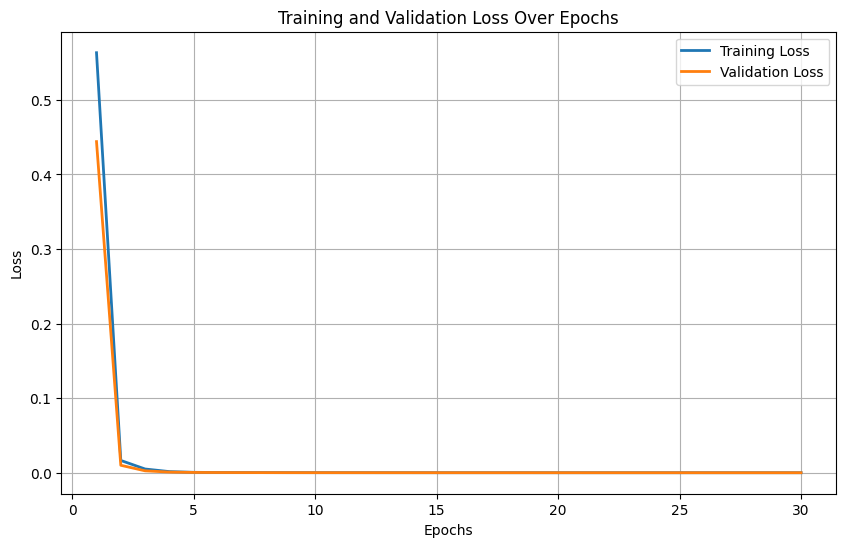

In [14]:
import json
import matplotlib.pyplot as plt

def plot_losses(metrics_path):
    """
    Plot training and validation losses over epochs.

    Parameters:
        metrics_path (str): Path to the JSON file containing train and val losses.
    """
    # Load metrics from JSON file
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    
    # Extract train and validation losses
    train_losses = metrics.get("train_class_loss", [])
    val_losses = metrics.get("val_class_loss", [])
    epochs = range(1, len(train_losses) + 1)
    
    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
    
    # Add plot details
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
metrics_path = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr0.1_wd0_metrics.json'
plot_losses(metrics_path)


In [ ]:
import torch
from tqdm import tqdm

def eval_vgg4(model, data_loader, device, model_path):
    """
    Evaluate the VGG4 model on a given data loader.

    Parameters:
        model: The model architecture (uninitialized weights).
        data_loader: DataLoader for the dataset to evaluate (e.g., validation or test set).
        device: 'cuda' or 'cpu' to evaluate on.
        model_path: Path to the saved model weights.
        
    Returns:
        avg_class_loss (float): Average classification loss on the dataset.
    """
    # Load the best saved model
    print(f"Loading model weights from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Define loss criterion
    classification_criterion = torch.nn.CrossEntropyLoss()

    total_class_loss = 0.0
    total_samples = 0

    # Evaluation loop
    with torch.no_grad():
        for images, (labels, bboxes) in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            print(labels)
            print(bboxes)
            # Forward pass
            class_preds, _ = model(images)
            B, C, H, W = class_preds.shape
            class_preds = class_preds.permute(0, 2, 3, 1).reshape(-1, C)

            # Prepare ground truth labels
            gt_labels = torch.zeros((B, H, W), dtype=torch.long, device=device)
            for b in range(B):
                for label, bbox in zip(labels[b], bboxes[b]):
                    x, y, w, h = bbox.int()
                    x1, x2 = max(0, x), min(W, x + w)
                    y1, y2 = max(0, y), min(H, y + h)
                    gt_labels[b, y1:y2, x1:x2] = label

            gt_labels = gt_labels.flatten()
            print(gt_labels)
            print(class_preds)

            # Compute loss
            class_loss = classification_criterion(class_preds, gt_labels)
            total_class_loss += class_loss.item() * gt_labels.size(0)  # Sum loss over batch
            total_samples += gt_labels.size(0)

    # Calculate average loss
    avg_class_loss = total_class_loss / total_samples

    print(f"Evaluation Complete - Average Classification Loss: {avg_class_loss:.4f}")
    return avg_class_loss


In [22]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
# Paths and configurations
model_path = "/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr0.1_wd0_epochs30.pth"  # Path to best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate on the validation set
avg_loss = eval_vgg4(model=model, data_loader=test_loader, device=device, model_path=model_path)
print(f"Average Validation Loss: {avg_loss:.4f}")



Loading model weights from: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr0.1_wd0_epochs30.pth


Evaluating:  25%|██▌       | 1/4 [00:00<00:01,  1.90it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[11.6314, -2.2284, -1.7089,  ..., -1.8789, -2.7743, -1.7738],
        [13.3972, -2.6320, -2.5759,  ..., -2.1440, -2.8635, -2.3072],
   

Evaluating:  50%|█████     | 2/4 [00:01<00:01,  1.85it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[11.6058, -2.1468, -1.7613,  ..., -1.8044, -2.6673, -1.7286],
        [13.0086, -2.4071, -2.5494,  ..., -2.0904, -2.7471, -2.2658],
   

Evaluating:  75%|███████▌  | 3/4 [00:01<00:00,  1.89it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[11.6626, -2.1564, -1.7961,  ..., -1.7700, -2.7229, -1.7404],
        [13.2813, -2.5809, -2.6205,  ..., -2.1677, -2.8985, -2.4025],
   

Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([[10.7975, -2.0971, -1.8052,  ..., -1.7764, -2.4808, -1.6282],
        [12.1828, -2.4214, -2.4682,  ..., -2.0472, -2.6697, -2.2580],
        [13.1277, -2.3359, -2.4720,  ..., -2.4975, -2.6822, -2.0833],
        ...,
        [13.1479, -2.4456, -2.4579,  ..., -2.7804, -2.6720, -2.8846],
        [12.9511, -2.6128, -2.5406,  ..., -3.4093, -2.6773, -3.0994],
        [11.2493, -1.7157, -2.2057,  ..., -2.3076, -2.0512, -2.2215]])
Evaluation Complete - Average Classification Loss: 0.0000
Average Validation Loss: 0.0000


Loading model from: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr1.0_wd0_epochs30.pth
Unique Predicted Classes: tensor([0])
Sample Predicted BBox Values: tensor([[[-0.0408, -0.0351, -0.0307,  0.0281],
         [-0.0699, -0.0129, -0.0157, -0.0029],
         [-0.0519, -0.0032, -0.0191,  0.0070],
         [-0.0503, -0.0120, -0.0113,  0.0099],
         [-0.0787, -0.0246, -0.0012,  0.0154]],

        [[-0.0477, -0.0249,  0.0394, -0.0234],
         [-0.0847, -0.0192,  0.0522, -0.0205],
         [-0.0732, -0.0411,  0.0566, -0.0030],
         [-0.0771, -0.0313,  0.0578, -0.0124],
         [-0.0935, -0.0282,  0.0731,  0.0224]],

        [[-0.0090,  0.0032,  0.0322, -0.0172],
         [-0.0260, -0.0031,  0.0227, -0.0118],
         [-0.0399, -0.0051,  0.0131, -0.0037],
         [-0.0517, -0.0057,  0.0109, -0.0084],
         [-0.0595, -0.0080,  0.0064, -0.0061]],

        [[-0.0240,  0.0040, -0.0091, -0.0156],
         [-0.0270,  0.0073, -0.

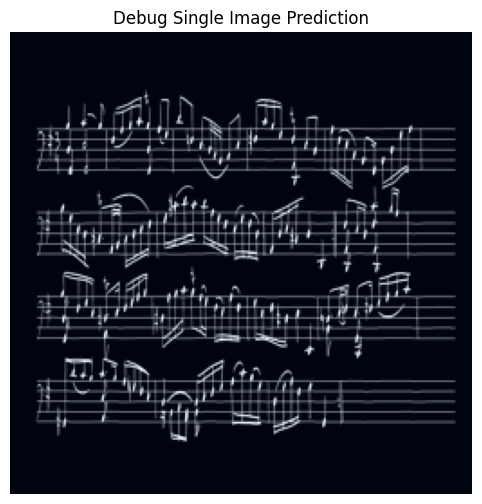

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def debug_single_prediction(model, test_loader, device, model_path):
    """
    Debug a single image's predictions (bounding boxes and class labels).
    """
    print(f"Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load a single batch
    images, (labels, bboxes) = next(iter(test_loader))
    images = images.to(device)
    
    with torch.no_grad():
        class_preds, bbox_preds = model(images)

    # Get the first image
    image = images[0].cpu().permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for visualization

    # Extract predictions for the first image
    predicted_classes = torch.argmax(class_preds[0], dim=0).cpu()
    predicted_bboxes = bbox_preds[0].permute(1, 2, 0).cpu()

    print("Unique Predicted Classes:", predicted_classes.unique())
    print("Sample Predicted BBox Values:", predicted_bboxes[:5, :5])

    # Plot the first image and bounding boxes
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)

    H, W = predicted_classes.shape
    for y in range(H):
        for x in range(W):
            label_idx = predicted_classes[y, x].item()
            if label_idx > 0:  # Ignore background
                bbox = predicted_bboxes[y, x]
                x1, y1, w, h = map(int, bbox)

                # Clamp to valid values
                x1, y1 = max(0, x1), max(0, y1)
                w, h = max(0, w), max(0, h)

                # Draw bounding box
                rect = patches.Rectangle((x1, y1), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1 - 5, f"Label: {label_idx}", color='red', fontsize=8, weight='bold')

    plt.title("Debug Single Image Prediction")
    plt.axis("off")
    plt.show()


model_path='/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr1.0_wd0_epochs30.pth'

debug_single_prediction(
    model=model,
    test_loader=test_loader,
    device=device,
    model_path=model_path
)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions_debug(model, test_loader, device, model_path, class_names, num_samples=1):
    print(f"Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_iter = iter(test_loader)
    plt.figure(figsize=(8, 6))

    with torch.no_grad():
        for _ in range(num_samples):
            images, (labels, bboxes) = next(test_iter)
            images = images.to(device)

            class_preds, bbox_preds = model(images)
            B, C, H, W = class_preds.shape

            for i in range(B):
                # Image preprocessing
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image - image.min()) / (image.max() - image.min())
                fig, ax = plt.subplots(1)
                ax.imshow(image)

                # Process predictions
                class_indices = torch.argmax(class_preds[i], dim=0).cpu()
                predicted_bboxes = bbox_preds[i].permute(1, 2, 0).cpu()

                # Draw bounding boxes
                for y in range(H):
                    for x in range(W):
                        label_idx = class_indices[y, x].item()
                        if label_idx > 0:  # Non-background
                            bbox = predicted_bboxes[y, x]
                            x1 = max(0, int(bbox[0]))
                            y1 = max(0, int(bbox[1]))
                            w = max(0, int(bbox[2]))
                            h = max(0, int(bbox[3]))

                            if w > 0 and h > 0:  # Only plot valid boxes
                                rect = patches.Rectangle((x1, y1), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
                                ax.add_patch(rect)
                                ax.text(x1, y1 - 5, class_names[label_idx], color='red', fontsize=8, weight='bold')

                ax.axis("off")
                plt.title("Predicted Bounding Boxes and Labels")
                plt.show()
                break


Loading model from: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr1.0_wd0_epochs30.pth


<Figure size 800x600 with 0 Axes>

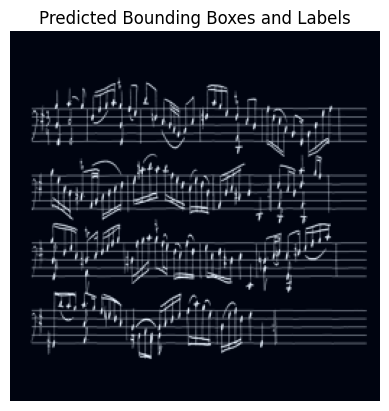

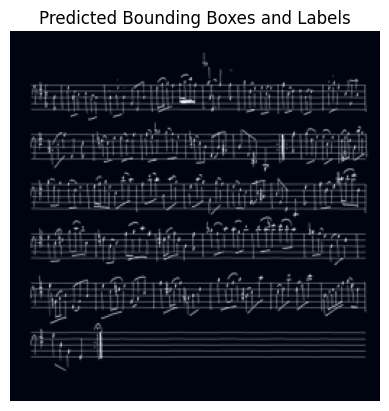

In [13]:
model_path='/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/vgg4_lr1.0_wd0_epochs30.pth'
class_names = extract_classes_from_bboxes(test_bboxes)
class_names = ["background", "note", "clef", "rest"]  # Replace with actual class names
visualize_predictions_debug(
    model=model,
    test_loader=test_loader,
    device=device,
    model_path=model_path,
    class_names=class_names,
    num_samples=2  # Visualize 2 samples
)

